In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Colabs

Machine Learning Crash Course uses Colaboratories (Colabs) for all programming exercises. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/). For more information about Colabs and how to use them, go to [Welcome to Colaboratory](https://research.google.com/colaboratory).

# Binary classification

In this Colab, you'll complete the following tasks:
- Examine a dataset containing measurements derived from images of two species of Turkish rice.
- Create a binary classifier to sort grains of rice into the two species.
- Evaluate the performance of the model.

## Learning objectives

By completing this Colab, you'll learn:
- How to train a binary classifier.
- How to calculate metrics for a binary classifier at different thresholds.
- How to compare AUC and ROC of two different models.

## Dataset

This Colab uses the Cinar and Koklu 2019 Osmancik and Cammeo rice dataset.

Provided with a CC0 license (see [Kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-dataset-commeo-and-osmancik) for more documentation; lengths and area are given in pixels). Cinar and Koklu also provide datasets for multiclass (5 species of rice), pistachios, raisins, grape leaves, and so on, at their [repository](https://www.muratkoklu.com/datasets/).

### Citation

Cinar, I. and Koklu, M., (2019). “Classification of Rice Varieties Using Artificial Intelligence Methods.” *International Journal of Intelligent Systems and Applications in Engineering*, 7(3), 188-194.

DOI: https://doi.org/10.18201/ijisae.2019355381


# Load Imports

In [2]:
# uncomment the line below to install the necessary packages
#!pip install -r requirements.txt


In [3]:
# Import the necessary libraries. Each library is used for specific tasks.

# 'io' is a standard library module used for handling file input/output operations.
import io

# 'keras' is a library for building and training neural networks. It provides an easy-to-use API for deep learning.
import keras

# 'pyplot' from the 'matplotlib' library is used for creating static, interactive, and animated visualizations.
from matplotlib import pyplot as plt

# 'Line2D' from 'matplotlib.lines' is useful for adding custom legend elements to plots.
from matplotlib.lines import Line2D

# 'numpy' is a powerful library for numerical computations, especially with arrays and matrices.
import numpy as np

# 'pandas' is a library for data manipulation and analysis, particularly useful for handling structured data.
import pandas as pd

# 'plotly.express' is a high-level plotting library for creating interactive visualizations.
import plotly.express as px

# 'dataclasses' is a module that provides a decorator and functions for creating simple classes to store data.
from dataclasses import dataclass

# Adjusting pandas settings to control how much data is displayed in output.
# These settings will make it easier to read data tables by limiting the number of rows shown.
pd.options.display.max_rows = 10  # Display a maximum of 10 rows when showing a DataFrame.
pd.options.display.float_format = "{:.1f}".format  # Format floating-point numbers to one decimal place.

# Print a message to confirm that the import statements ran successfully.
print("Ran the import statements.")


Ran the import statements.


In [4]:
# Step 1: Load the dataset
# The dataset is stored online at a specific URL. We use pandas' read_csv() function to load it.
# The read_csv() function can load data from both local files and online sources.
# In this case, we are loading the file directly from the internet.
rice_dataset_raw = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/Rice_Cammeo_Osmancik.csv")

# Step 2: Check if the dataset loaded successfully
# The .head() method of a pandas DataFrame displays the first few rows of the dataset.
# This is useful for verifying that the data has been loaded correctly.
print("Dataset loaded successfully:")

# Display the first 5 rows (default behavior of .head())
# This helps beginners understand the structure of the dataset (columns and sample data).
print(rice_dataset_raw.head())

# Notes for beginners:
# - A DataFrame is like a table in Excel or SQL, where data is organized in rows and columns.
# - Each column in the dataset represents a specific type of data (e.g., "weight", "length").
# - Each row represents a single record or observation (e.g., details about one rice grain).

Dataset loaded successfully:
    Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231      525.6              229.7               85.1           0.9   
1  14656      494.3              206.0               91.7           0.9   
2  14634      501.1              214.1               87.8           0.9   
3  13176      458.3              193.3               87.4           0.9   
4  14688      507.2              211.7               89.3           0.9   

   Convex_Area  Extent   Class  
0        15617     0.6  Cammeo  
1        15072     0.6  Cammeo  
2        14954     0.7  Cammeo  
3        13368     0.6  Cammeo  
4        15262     0.6  Cammeo  


Once the dataset has been loaded via the cell above, select specific columns to show summary statistics of the numerical features in the dataset.

See the Kaggle [dataset documentation](https://www.kaggle.com/datasets/muratkokludataset/rice-dataset-commeo-and-osmancik), especially the **Provenance** section, for explanations of what each feature means and how they were calculated.

In [5]:
# Extract specific columns and provide statistics on the dataset.

# Step 1: Select important columns from the raw dataset
# The dataset may contain many columns, but we are only interested in specific ones for our analysis.
# Here, we create a new DataFrame, `rice_dataset`, by selecting only the columns we care about:
# - 'Area': The size of the rice grain.
# - 'Perimeter': The length of the outer boundary of the rice grain.
# - 'Major_Axis_Length': The length of the longest axis of the rice grain.
# - 'Minor_Axis_Length': The length of the shortest axis of the rice grain.
# - 'Eccentricity': A measure of how elongated the rice grain is.
# - 'Convex_Area': The area of the smallest convex shape that can enclose the rice grain.
# - 'Extent': The ratio of the area of the rice grain to the area of the bounding box.
# - 'Class': The type of rice grain (e.g., 'Cammeo' or 'Osmancik').

rice_dataset = rice_dataset_raw[[
    'Area',
    'Perimeter',
    'Major_Axis_Length',
    'Minor_Axis_Length',
    'Eccentricity',
    'Convex_Area',
    'Extent',
    'Class',
]]

# Step 2: Generate descriptive statistics for the selected columns
# The describe() function provides a quick overview of the dataset:
# - Count: The number of non-missing (valid) values for each column.
# - Mean: The average value of each column.
# - Std: The standard deviation (a measure of spread or variability).
# - Min: The smallest value in each column.
# - 25%, 50%, 75%: Percentiles (help understand the distribution of values).
# - Max: The largest value in each column.

# Displaying the summary statistics
print("Summary statistics of the selected dataset:")
rice_dataset.describe()

# Notes for beginners:
# - Using .describe() is a great way to quickly understand the range, distribution, and central tendencies of your data.
# - You can use it to detect potential data issues, such as missing or outlier values.


Summary statistics of the selected dataset:


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0
mean,12667.7,454.2,188.8,86.3,0.9,12952.5,0.7
std,1732.4,35.6,17.4,5.7,0.0,1777.0,0.1
min,7551.0,359.1,145.3,59.5,0.8,7723.0,0.5
25%,11370.5,426.1,174.4,82.7,0.9,11626.2,0.6
50%,12421.5,448.9,185.8,86.4,0.9,12706.5,0.6
75%,13950.0,483.7,203.6,90.1,0.9,14284.0,0.7
max,18913.0,548.4,239.0,107.5,0.9,19099.0,0.9


## Task 1: Describe the data

From the summary statistics above, answer the following questions:
- What are the min and max lengths (major axis length, given in pixels) of the rice grains?
- What is the range of areas between the smallest and largest rice grains?
- How many standard deviations (`std`) is the largest rice grain's perimeter from the mean?

In [6]:
# Solutions: Analyze key properties of the dataset.

# Step 1: Analyze the length of the grains
# We use the .min() and .max() methods to find the shortest and longest grains.
print(
    f'The shortest grain is {rice_dataset.Major_Axis_Length.min():.1f}px long,'
    f' while the longest is {rice_dataset.Major_Axis_Length.max():.1f}px.'
)

# Step 2: Analyze the area of the grains
# Similarly, .min() and .max() are used to find the smallest and largest grain areas.
print(
    f'The smallest rice grain has an area of {rice_dataset.Area.min()}px, while'
    f' the largest has an area of {rice_dataset.Area.max()}px.'
)

# Step 3: Analyze the perimeter of the grains
# Here, we calculate the largest perimeter and compare it to the mean and standard deviation.
# This helps understand how unusual the largest perimeter value is compared to the rest of the dataset.
print(
    'The largest rice grain, with a perimeter of'
    f' {rice_dataset.Perimeter.max():.1f}px, is'
    f' ~{(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f} standard'
    f' deviations ({rice_dataset.Perimeter.std():.1f}) from the mean'
    f' ({rice_dataset.Perimeter.mean():.1f}px).'
)

# Step 4: Display the calculation explicitly for transparency
# We display the formula and result for calculating the z-score (standard deviations from the mean).
print(
    f'This is calculated as: ({rice_dataset.Perimeter.max():.1f} -'
    f' {rice_dataset.Perimeter.mean():.1f})/{rice_dataset.Perimeter.std():.1f} ='
    f' {(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f}'
)

# Notes for Beginners:
# - `min()` and `max()` methods find the smallest and largest values in a column.
# - `mean()` calculates the average value of a column.
# - `std()` calculates the standard deviation, a measure of how spread out the values are.
# - The z-score tells us how many standard deviations a value is from the mean.


The shortest grain is 145.3px long, while the longest is 239.0px.
The smallest rice grain has an area of 7551px, while the largest has an area of 18913px.
The largest rice grain, with a perimeter of 548.4px, is ~2.6 standard deviations (35.6) from the mean (454.2px).
This is calculated as: (548.4 - 454.2)/35.6 = 2.6


# Explore the dataset

Plot some of the features against each other, including in 3D.


In [7]:
# Create five 2D scatter plots of the features against each other, color-coded by class.

# Step 1: Define pairs of features to plot against each other.
# Each pair (x_axis_data, y_axis_data) represents the x and y features for the scatter plot.
# Example: The first pair ('Area', 'Eccentricity') will plot 'Area' on the x-axis and 'Eccentricity' on the y-axis.
feature_pairs = [
    ('Area', 'Eccentricity'),
    ('Convex_Area', 'Perimeter'),
    ('Major_Axis_Length', 'Minor_Axis_Length'),
    ('Perimeter', 'Extent'),
    ('Eccentricity', 'Major_Axis_Length'),
]

# Step 2: Loop through each pair and create a scatter plot using Plotly Express.
# Plotly Express (px) is a library that makes it easy to create interactive visualizations.
# - The `x` parameter sets the x-axis data.
# - The `y` parameter sets the y-axis data.
# - The `color` parameter is used to group points by the 'Class' column.
# - The `.show()` method displays the plot in an interactive format.
for x_axis_data, y_axis_data in feature_pairs:
    fig = px.scatter(
        rice_dataset,  # The dataset to use for the plot
        x=x_axis_data,  # Feature for the x-axis
        y=y_axis_data,  # Feature for the y-axis
        color='Class',  # Color points by the 'Class' column (e.g., different rice types)
        title=f"{x_axis_data} vs {y_axis_data}",  # Add a descriptive title for each plot
        labels={x_axis_data: x_axis_data, y_axis_data: y_axis_data}  # Label axes
    )
    fig.show()  # Display the plot

# Notes for Beginners:
# - Scatter plots are great for visualizing relationships between two continuous variables.
# - Color-coding by 'Class' helps us see if the different rice types have distinct patterns.
# - `Plotly Express` is interactive, so you can hover over points and zoom into the plot.
# - Each feature pair provides insights into how the features relate to each other and to the class.


## Task 2: Visualize samples in 3D

Try graphing three of the features in 3D against each other.

In [8]:
# Plot three features in 3D by specifying their names.

# Step 1: Define the features for the 3D plot.
# These variables specify which features will be plotted on the x, y, and z axes.
# You can change their values to explore different combinations of features.
x_axis_data = 'Area'  # Feature for the x-axis
y_axis_data = 'Eccentricity'  # Feature for the y-axis
z_axis_data = 'Extent'  # Feature for the z-axis

# Step 2: Create a 3D scatter plot using Plotly Express.
# The `scatter_3d()` function generates a 3D visualization where:
# - `x` specifies the feature to plot on the x-axis.
# - `y` specifies the feature to plot on the y-axis.
# - `z` specifies the feature to plot on the z-axis.
# - `color` groups the data points by the 'Class' column (e.g., different rice types).
fig = px.scatter_3d(
    rice_dataset,  # The dataset to use for the plot
    x=x_axis_data,  # Data for the x-axis
    y=y_axis_data,  # Data for the y-axis
    z=z_axis_data,  # Data for the z-axis
    color='Class',  # Color points by the 'Class' column
    title=f"3D Scatter Plot: {x_axis_data}, {y_axis_data}, {z_axis_data}",  # Add a title
    labels={  # Provide axis labels
        x_axis_data: x_axis_data,
        y_axis_data: y_axis_data,
        z_axis_data: z_axis_data
    }
)

# Step 3: Display the interactive 3D plot.
# The `.show()` method renders the plot in an interactive format, allowing rotation, zoom, and exploration.
fig.show()

# Notes for Beginners:
# - 3D scatter plots are useful for visualizing relationships between three features.
# - The `color='Class'` argument differentiates data points by their class, showing how the classes separate in 3D space.
# - You can change `x_axis_data`, `y_axis_data`, and `z_axis_data` to plot different feature combinations.
# - In the VSCode notebook, interactive 3D plots allow you to rotate and zoom into the visualization for a deeper understanding.


In [9]:
# One possible solution: 3D Scatter Plot of Major Axis Length, Area, and Eccentricity

# Step 1: Create a 3D scatter plot to visualize three features.
# In this example:
# - The x-axis represents 'Eccentricity', which measures how elongated the rice grain is.
# - The y-axis represents 'Area', which is the size of the rice grain.
# - The z-axis represents 'Major_Axis_Length', the longest dimension of the rice grain.
# - The `color='Class'` argument groups the data points by rice type (e.g., Cammeo or Osmancik).

fig = px.scatter_3d(
    rice_dataset,  # The dataset containing the features
    x='Eccentricity',  # Feature to plot on the x-axis
    y='Area',  # Feature to plot on the y-axis
    z='Major_Axis_Length',  # Feature to plot on the z-axis
    color='Class',  # Color-code the points based on the 'Class' column
    title="3D Scatter Plot: Eccentricity, Area, and Major Axis Length",  # Descriptive plot title
    labels={  # Provide meaningful labels for the axes
        'Eccentricity': 'Eccentricity',
        'Area': 'Area',
        'Major_Axis_Length': 'Major Axis Length'
    }
)

# Step 2: Display the plot.
# The `.show()` method generates an interactive plot, allowing you to rotate, zoom, and explore.
fig.show()

# Notes for Beginners:
# - A 3D scatter plot helps visualize the relationship between three features at once.
# - Color-coding by class shows how different rice types separate based on these features.
# - This plot can help identify patterns or clusters in the dataset.
# - You can modify the features in `x`, `y`, and `z` to explore other combinations of variables.


If we were to pick three features, it seems that major axis length, area, and eccentricity might contain most of the information that differentiates the two classes. Other combinations may work as well.

Run the previous code cell to graph those three features if you haven't already.

It seems like a distinct class boundary appears in the plane of these three features. We'll train a model on just these features, then another model on the complete set of features, and compare their performance.

## Normalize data

When creating a model with multiple features, the values of each feature should span roughly the same range.  If one feature's values range from 500 to 100,000 and another feature's values range from 2 to 12, the model will need to have weights of extremely low or extremely high values to be able to combine these features effectively. This could result in a low quality model.  To avoid this,
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model.

This can be done by converting each raw value to its Z-score. The **Z-score** for a given value is how many standard deviations away from the mean the value is.

Consider a feature with a mean of 60 and a standard deviation of 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

Now normalize the numerical values in the rice dataset by converting them to Z-scores.

In [10]:
# Normalize the dataset by calculating Z-scores for numerical columns.

# Step 1: Calculate the mean and standard deviation for each numerical feature.
# - The mean is the average value of the column.
# - The standard deviation (std) measures how spread out the values are around the mean.
feature_mean = rice_dataset.mean(numeric_only=True)  # Mean of each numerical column
feature_std = rice_dataset.std(numeric_only=True)  # Standard deviation of each numerical column

# Step 2: Identify the numerical columns.
# - Using select_dtypes('number') ensures we only process columns with numeric data types.
numerical_features = rice_dataset.select_dtypes('number').columns

# Step 3: Normalize the numerical data.
# - Z-score normalization subtracts the mean from each value, then divides by the std deviation.
# - This transformation rescales the data to have a mean of 0 and a std deviation of 1.
normalized_dataset = (rice_dataset[numerical_features] - feature_mean) / feature_std

# Step 4: Add the 'Class' column back to the normalized dataset.
# - The 'Class' column is categorical, so we don't normalize it but include it in the new DataFrame.
normalized_dataset['Class'] = rice_dataset['Class']

# Step 5: Examine the first few rows of the normalized dataset.
# - The .head() method displays the first 5 rows to verify the transformation.
# - Most Z-scores should now fall between -2 and +2, indicating the data has been standardized.
print("First 5 rows of the normalized dataset:")
normalized_dataset.head()

# Notes for Beginners:
# - **Why Normalize?** Normalization ensures that features with different scales (e.g., 'Area' vs. 'Extent') have comparable ranges.
# - **What is a Z-score?** It tells us how many standard deviations a value is from the mean. A Z-score of 0 means the value is equal to the mean.
# - **Why use .mean() and .std()?** These methods calculate the necessary statistics for normalization.
# - **Why keep 'Class'?** The 'Class' column represents the rice type and isn't numerical, so it's preserved for analysis or modeling.


First 5 rows of the normalized dataset:


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.5,2.0,2.3,-0.2,2.0,1.5,-1.2,Cammeo
1,1.1,1.1,1.0,0.9,0.4,1.2,-0.6,Cammeo
2,1.1,1.3,1.5,0.3,1.2,1.1,0.4,Cammeo
3,0.3,0.1,0.3,0.2,0.2,0.2,-0.3,Cammeo
4,1.2,1.5,1.3,0.5,1.0,1.3,-0.2,Cammeo


# Set the random seeds

To make experiments reproducible, we set the seed of the random number generators. This means that the order in which the data is shuffled, the values of the random weight initializations, etc, will all be the same each time the colab is run.

In [11]:
# Set the random seed for reproducibility.
# - This ensures that random operations (e.g., weight initialization, data shuffling) 
#   yield the same results across multiple runs of the code.
# - Useful for debugging and comparing experiments.
# - The seed value (42) can be any integer; it's a common convention to use 42.
keras.utils.set_random_seed(42)


## Label and split data

To train the model, we'll arbritrarily assign the Cammeo species a label of '1' and the Osmancik species a label of '0'.

In [12]:
# Create a new column 'Class_Bool' that assigns binary labels to the rice classes.
# - 'Cammeo' is labeled as 1 (True).
# - 'Osmancik' is labeled as 0 (False).
normalized_dataset['Class_Bool'] = (
    normalized_dataset['Class'] == 'Cammeo'  # Check if the class is 'Cammeo' (True/False)
).astype(int)  # Convert the True/False values to integers (1 for True, 0 for False)

# Randomly select and display 10 rows from the dataset.
# - The .sample(10) method selects 10 random rows, which is useful for quickly inspecting the data.
normalized_dataset.sample(10)


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
1011,-0.1,0.1,-0.1,0.2,-0.1,-0.0,-1.0,Cammeo,1
3185,-0.1,-0.5,-0.5,0.4,-0.8,-0.2,-0.3,Osmancik,0
3698,0.1,-0.1,-0.4,0.9,-1.1,0.1,-0.2,Osmancik,0
897,0.2,0.5,0.8,-0.5,1.2,0.2,1.5,Cammeo,1
3245,-1.3,-1.3,-0.9,-1.6,0.5,-1.4,-1.1,Osmancik,0
478,0.2,0.2,0.4,-0.0,0.5,0.2,1.7,Cammeo,1
1731,-0.4,-0.8,-0.8,0.3,-1.0,-0.5,-0.4,Osmancik,0
1025,0.6,0.7,0.6,0.3,0.5,0.6,-0.5,Cammeo,1
429,1.2,1.2,1.4,0.6,1.0,1.2,1.8,Cammeo,1
1330,-0.4,-0.0,0.4,-1.3,1.4,-0.5,-0.1,Cammeo,1


We can then randomize and partition the dataset into train, test, and validation splits, consisting of 80%, 10%, and 10% of the dataset respectively.

In [13]:
# Step 1: Calculate indices for splitting the dataset into training, validation, and test sets.
# - `number_samples` gives the total number of rows in the dataset.
number_samples = len(normalized_dataset)

# - `index_80th` represents the 80th percentile, where the training data ends.
index_80th = round(number_samples * 0.8)

# - `index_90th` represents the 90th percentile, where the validation data ends.
#   It starts at the 80th percentile and includes the next 10% of the data.
index_90th = index_80th + round(number_samples * 0.1)

# Step 2: Shuffle the dataset to randomize the order of rows.
# - `.sample(frac=1)` shuffles the entire dataset (`frac=1` means use 100% of the rows).
# - `random_state=100` ensures reproducibility of the shuffle.
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)

# Step 3: Split the dataset into training, validation, and test sets.
# - Training data (80%): Rows from the start to the 80th percentile.
train_data = shuffled_dataset.iloc[0:index_80th]

# - Validation data (10%): Rows from the 80th percentile to the 90th percentile.
validation_data = shuffled_dataset.iloc[index_80th:index_90th]

# - Test data (10%): Rows from the 90th percentile to the end.
test_data = shuffled_dataset.iloc[index_90th:]

# Step 4: Display the first five rows of the test set to verify the split.
test_data.head()

# Notes for Beginners:
# - Splitting data into train, validation, and test sets is critical for building and evaluating models:
#   - **Train set:** Used to train the model.
#   - **Validation set:** Used to tune model parameters and avoid overfitting.
#   - **Test set:** Used to evaluate the final performance of the model on unseen data.
# - Shuffling ensures the data is evenly distributed across the splits, avoiding bias.
# - `.iloc[start:end]` selects rows by index, which is used here to define the data splits.


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
2405,-0.4,-0.7,-0.8,0.3,-1.1,-0.4,0.3,Osmancik,0
3062,-0.2,-0.0,0.2,-0.7,0.8,-0.2,1.6,Osmancik,0
1155,1.4,1.2,1.1,1.2,0.3,1.3,0.7,Cammeo,1
660,1.2,1.0,0.8,1.3,-0.0,1.2,-0.6,Cammeo,1
2451,-1.2,-1.2,-1.4,-0.3,-1.5,-1.1,0.1,Osmancik,0


It's important to prevent the model from getting the label as input during training, which is called label leakage. This can be done by storing features and labels as separate variables.

In [14]:
# Step 1: Define the label columns to separate features from labels.
# - The `label_columns` list contains the names of columns that will be treated as labels (target variables).
# - These columns ('Class', 'Class_Bool') won't be used as features for model training.
label_columns = ['Class', 'Class_Bool']

# Step 2: Separate features and labels for the training set.
# - `train_features` contains all columns except the label columns.
# - `drop(columns=label_columns)` removes the specified columns from the DataFrame.
train_features = train_data.drop(columns=label_columns)

# - `train_labels` contains the 'Class_Bool' column, converted to a NumPy array for compatibility with many ML frameworks.
train_labels = train_data['Class_Bool'].to_numpy()

# Step 3: Separate features and labels for the validation set.
# - `validation_features` contains all columns except the label columns.
validation_features = validation_data.drop(columns=label_columns)

# - `validation_labels` contains the 'Class_Bool' column as a NumPy array.
validation_labels = validation_data['Class_Bool'].to_numpy()

# Step 4: Separate features and labels for the test set.
# - `test_features` contains all columns except the label columns.
test_features = test_data.drop(columns=label_columns)

# - `test_labels` contains the 'Class_Bool' column as a NumPy array.
test_labels = test_data['Class_Bool'].to_numpy()

# Notes for Beginners:
# - **Features vs. Labels:**
#   - Features are the input variables used by the model to make predictions.
#   - Labels (or targets) are the ground truth values the model tries to predict.
# - **Why use `.drop()` for features?**
#   - To exclude the label columns so the model doesn't accidentally "cheat" by using them as inputs.
# - **Why convert labels to NumPy arrays?**
#   - NumPy arrays are a common format required by many machine learning libraries (e.g., TensorFlow, Keras).
# - This step prepares the data for training, validation, and testing in a supervised learning workflow.


## Train the model

### Choose the input features

To start with, we'll train a model on `Eccentricity`, `Major_Axis_Length,` and `Area`.

In [15]:
# Define the features to be used as inputs for the model.

# - `input_features` is a list of column names from the dataset.
# - These columns represent the features (independent variables) that the model will use for training.
# - The selected features are:
#   - 'Eccentricity': A measure of how elongated the rice grain is.
#   - 'Major_Axis_Length': The longest dimension of the rice grain.
#   - 'Area': The size of the rice grain.

input_features = [
    'Eccentricity',
    'Major_Axis_Length',
    'Area',
]

# Notes for Beginners:
# - This list specifies the subset of features (columns) from the dataset that will be used for model input.
# - Choosing relevant features is an important step in building a machine learning model, as irrelevant features can reduce accuracy.
# - These features should ideally have been preprocessed or normalized, as done earlier.


## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(inputs, learning_rate, metrics)`, which defines the model's architecture.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Note: create_model applies the sigmoid function to perform [logistic regression](https://developers.google.com/machine-learning/crash-course/logistic-regression).

We also define two helpful data structures: `ExperimentSettings` and `Experiment`. We use these simple classes to keep track of our experiments, allowing us to know what hyperparameters were used and what the results were. In `ExperimentSettings`, we store all values describing an experiment (i.e., hyperparameters). Then, we store the results of a training run (i.e., the model and the training metrics) into an `Experiment` instance, along with the `ExperimentSettings` used for that experiment.

In [16]:
# Define the functions that create and train a model.

# Import the `dataclasses` module to create structured, lightweight classes.
import dataclasses


@dataclasses.dataclass()
class ExperimentSettings:
    """Stores hyperparameters and input features for training a model."""
    learning_rate: float  # How fast the model updates weights during training (smaller values = slower updates).
    number_epochs: int  # How many complete passes the model makes over the training data.
    batch_size: int  # The number of data samples processed at once before updating the model.
    classification_threshold: float  # The threshold to classify outputs as 1 (positive) or 0 (negative).
    input_features: list[str]  # Names of the input features (columns) used by the model.


@dataclasses.dataclass()
class Experiment:
    """Stores settings, model, and results from a training run."""
    name: str  # Name to identify this experiment (useful for comparing multiple runs).
    settings: ExperimentSettings  # Stores the hyperparameters and input features used in this run.
    model: keras.Model  # The trained Keras model after running.
    epochs: np.ndarray  # List or array of epochs completed during training.
    metrics_history: keras.callbacks.History  # Logs of the training process, including metrics like accuracy or loss.

    def get_final_metric_value(self, metric_name: str) -> float:
        """Retrieve the final value of a specified metric from the training history."""
        # Check if the metric is in the training history.
        if metric_name not in self.metrics_history:
            raise ValueError(
                f'Unknown metric {metric_name}: available metrics are'
                f' {list(self.metrics_history.columns)}'
            )
        # Return the last recorded value of the requested metric.
        return self.metrics_history[metric_name].iloc[-1]


def create_model(
    settings: ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
    """Create and compile a simple neural network model for binary classification."""
    # Step 1: Define input layers for each feature in `settings.input_features`.
    # - Each feature gets its own input layer (1 value per input, shape=(1,)).
    # - Example: If `input_features = ['Feature1', 'Feature2']`, the model will expect 2 inputs.
    model_inputs = [
        keras.Input(name=feature, shape=(1,)) for feature in settings.input_features
    ]

    # Step 2: Combine all inputs into a single tensor using a Concatenate layer.
    # - This step merges all feature inputs into one input vector for further processing.
    concatenated_inputs = keras.layers.Concatenate()(model_inputs)

    # Step 3: Add a Dense (fully connected) layer for prediction.
    # - The Dense layer uses 1 unit (output size = 1) for binary classification.
    # - Activation = sigmoid: Outputs a value between 0 and 1, useful for binary probabilities.
    dense = keras.layers.Dense(
        units=1,
        input_shape=(1,),
        name='dense_layer',
        activation=keras.activations.sigmoid
    )

    # Step 4: Connect the Dense layer to the concatenated inputs to form the output.
    model_output = dense(concatenated_inputs)

    # Step 5: Build the complete model.
    # - Define the inputs and outputs of the model.
    model = keras.Model(inputs=model_inputs, outputs=model_output)

    # Step 6: Compile the model to prepare it for training.
    # - Optimizer: RMSprop, which adjusts learning rates adaptively for better training.
    # - Loss: BinaryCrossentropy, suited for binary classification tasks.
    # - Metrics: Additional performance measures specified by the user (e.g., accuracy).
    model.compile(
        optimizer=keras.optimizers.RMSprop(settings.learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )

    # Return the compiled model, ready for training.
    return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ExperimentSettings,
) -> Experiment:
    """Train the model on the provided dataset."""
    # Step 1: Prepare the features as input to the model.
    # - Convert the DataFrame into a dictionary where each key is a feature name,
    #   and each value is a NumPy array of the corresponding feature values.
    # - Example: {'Feature1': array([...]), 'Feature2': array([...])}.
    features = {
        feature_name: np.array(dataset[feature_name])
        for feature_name in settings.input_features
    }

    # Step 2: Train the model using Keras' `fit` method.
    # - `x=features`: Inputs to the model (feature values).
    # - `y=labels`: Target outputs (actual class labels).
    # - `batch_size`: Number of samples processed together in one training step.
    # - `epochs`: Number of complete passes through the training data.
    history = model.fit(
        x=features,
        y=labels,
        batch_size=settings.batch_size,
        epochs=settings.number_epochs,
    )

    # Step 3: Create an Experiment object to store the results.
    # - Store experiment details (name, settings, model, training history).
    return Experiment(
        name=experiment_name,  # Name of the experiment.
        settings=settings,  # Experiment settings (hyperparameters and input features).
        model=model,  # The trained Keras model.
        epochs=history.epoch,  # List of completed epochs.
        metrics_history=pd.DataFrame(history.history),  # Metrics recorded during training.
    )


# Indicate that the functions have been successfully defined.
print('Defined the create_model and train_model functions.')


Defined the create_model and train_model functions.


## Define a plotting function

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) function plots one or more curves, showing how various classification metrics change with each epoch.

In [17]:
# Define the plotting function to visualize experiment metrics.

def plot_experiment_metrics(experiment: Experiment, metrics: list[str]):
    """
    Plot the performance metrics of a training experiment over epochs.

    Args:
    - experiment (Experiment): An Experiment object containing training details and metrics.
    - metrics (list[str]): A list of metric names to plot (e.g., ['loss', 'accuracy']).

    Returns:
    - A matplotlib plot showing the metrics' progression over epochs.
    """
    # Create a new figure for the plot with a defined size (12 inches by 8 inches).
    plt.figure(figsize=(12, 8))

    # Iterate over each metric provided in the metrics list.
    for metric in metrics:
        # Plot the metric's values over epochs.
        # - `experiment.epochs`: The x-axis, representing the number of completed epochs.
        # - `experiment.metrics_history[metric]`: The y-axis, representing the metric values.
        plt.plot(
            experiment.epochs,  # X-axis: Epochs
            experiment.metrics_history[metric],  # Y-axis: Metric values for the specified metric
            label=metric  # Label the curve with the metric name (for the legend).
        )

    # Add labels, grid, and legend to the plot.
    plt.xlabel("Epoch")  # Label for the x-axis.
    plt.ylabel("Metric value")  # Label for the y-axis.
    plt.grid()  # Add a grid to the plot for better readability.
    plt.legend()  # Display the legend to identify different metrics.

# Print a message to confirm that the function has been defined.
print("Defined the plot_experiment_metrics function.")


Defined the plot_experiment_metrics function.


## Invoke the creating, training, and plotting functions

The following code specifies the hyperparameters, invokes the
functions to create and train the model, then plots the results, including accuracy, precision, and recall.

Classification threshold is set at .35. Try playing with the threshold, then the learning rate, to see what changes.

Epoch 1/60


c:\Users\Zain_\anaconda3\envs\datascience_core\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6879 - auc: 0.8524 - loss: 0.5124 - precision: 0.5897 - recall: 0.9565   
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7115 - auc: 0.8697 - loss: 0.4899 - precision: 0.6103 - recall: 0.9537 
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7330 - auc: 0.8822 - loss: 0.4712 - precision: 0.6293 - recall: 0.9575 
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7512 - auc: 0.8931 - loss: 0.4537 - precision: 0.6473 - recall: 0.9551 
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7643 - auc: 0.9022 - loss: 0.4373 - precision: 0.6606 - recall: 0.9553 
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7727 - auc: 0.9105 - loss: 0.4220 - precision: 0.6698 - recall: 0.9533 
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7829 - auc: 0.9176 - loss: 0.4076 - precision: 0.6812 - recall: 0.9521 
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

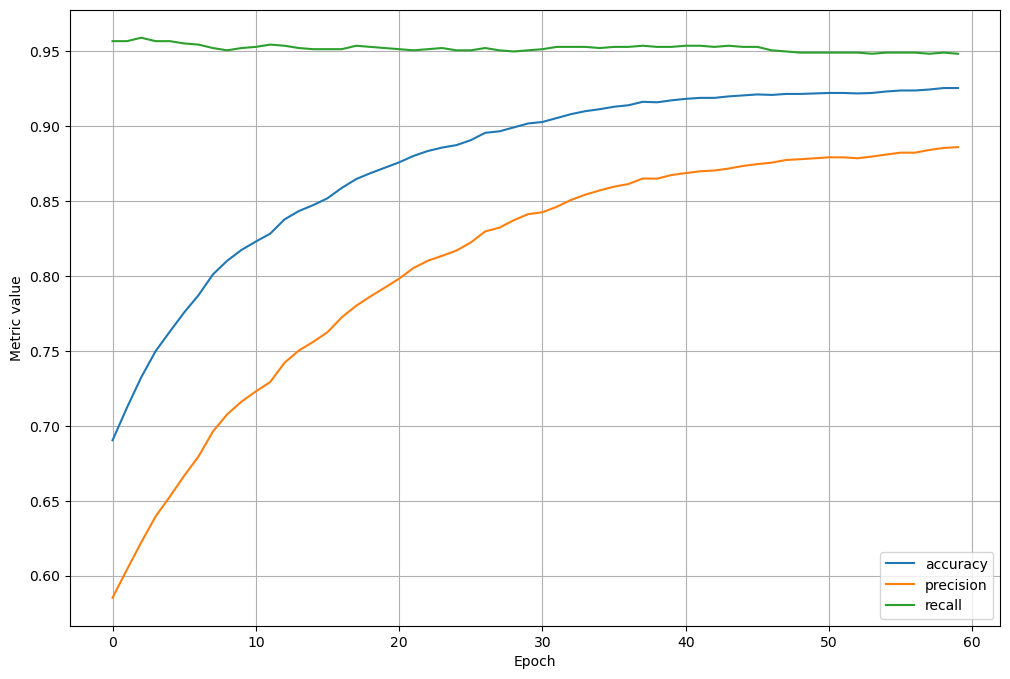

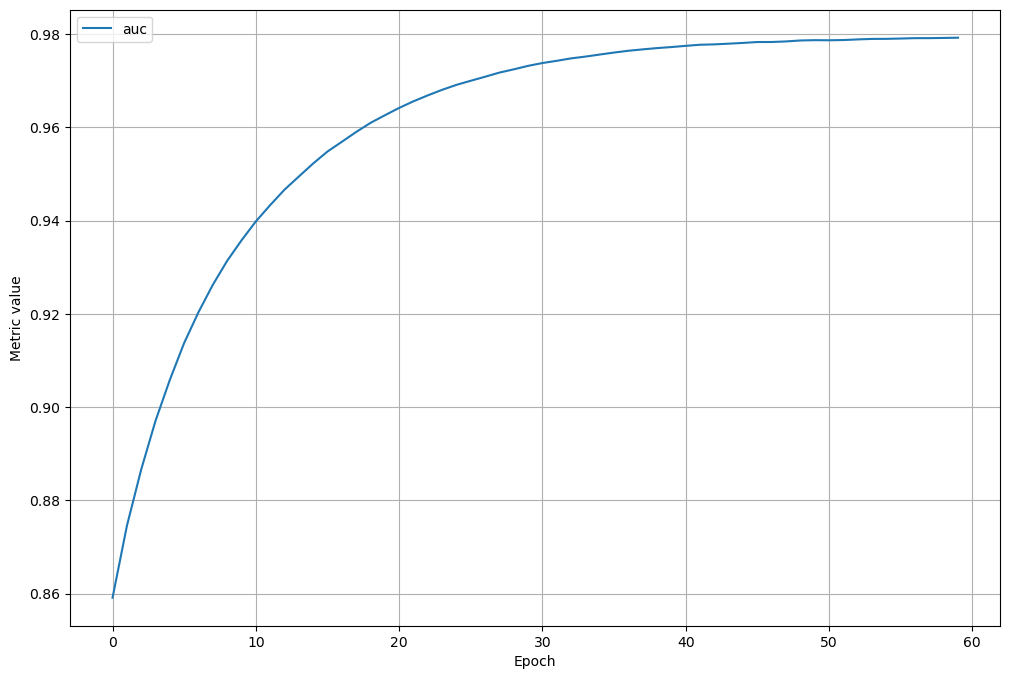

In [18]:
# Define the settings for our first experiment.
# - This includes hyperparameters, the classification threshold, and input features.
settings = ExperimentSettings(
    learning_rate=0.001,  # The step size used during model training to update weights.
    number_epochs=60,  # The number of complete passes through the training data.
    batch_size=100,  # The number of samples processed before updating model weights.
    classification_threshold=0.35,  # Threshold to classify outputs as positive (1) or negative (0).
    input_features=input_features,  # List of features used as inputs for the model.
)

# Define the metrics to evaluate the model's performance during training.
metrics = [
    keras.metrics.BinaryAccuracy(  # Measures the percentage of correct predictions.
        name='accuracy', threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(  # Measures how many predicted positives are correct.
        name='precision', thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(  # Measures how many actual positives are correctly predicted.
        name='recall', thresholds=settings.classification_threshold
    ),
    keras.metrics.AUC(  # Computes the Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC).
        num_thresholds=100, name='auc'
    ),
]

# Step 1: Create the model using the defined settings and metrics.
# - The model is a simple binary classification neural network.
model = create_model(settings, metrics)

# Step 2: Train the model on the training data.
# - 'baseline' is the name of this experiment (used for tracking).
# - `train_features`: The input features from the training dataset.
# - `train_labels`: The ground truth labels for the training data.
# - `settings`: The hyperparameters and input features used for this experiment.
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Step 3: Plot the metrics (accuracy, precision, recall) over epochs.
# - The first plot visualizes how accuracy, precision, and recall change as training progresses.
plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])

# Step 4: Plot the AUC metric over epochs in a separate graph.
# - AUC helps assess how well the model separates positive and negative classes.
plot_experiment_metrics(experiment, ['auc'])


AUC is calculated across all possible thresholds (in practice in the code above, 100 thresholds), while accuracy, precision, and recall are calculated for only the specified threshold. For this reason they are shown separately above.

## Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [19]:
# Define a function to evaluate the model on a test dataset.
def evaluate_experiment(
    experiment: Experiment,  # The experiment object containing the trained model and settings.
    test_dataset: pd.DataFrame,  # The test dataset features.
    test_labels: np.array  # The true labels for the test dataset.
) -> dict[str, float]:  # Returns a dictionary of metric names and their values.
    """
    Evaluate the trained model on the test dataset and return the evaluation metrics.

    Args:
    - experiment: The Experiment object that includes the model and its settings.
    - test_dataset: A DataFrame containing the test dataset features.
    - test_labels: A NumPy array containing the ground truth labels for the test data.

    Returns:
    - A dictionary of metric names and their corresponding values on the test dataset.
    """
    # Prepare the test features in the required format for the model.
    # - Convert each column in the test dataset to a NumPy array.
    # - Keys correspond to feature names; values are arrays of feature values.
    features = {
        feature_name: np.array(test_dataset[feature_name])
        for feature_name in experiment.settings.input_features
    }

    # Evaluate the model on the test dataset.
    # - `x=features`: Inputs to the model (test feature values).
    # - `y=test_labels`: True labels for the test data.
    # - `batch_size`: Number of samples processed at once during evaluation.
    # - `verbose=0`: Suppresses the progress bar during evaluation.
    # - `return_dict=True`: Returns the results as a dictionary.
    return experiment.model.evaluate(
        x=features,
        y=test_labels,
        batch_size=settings.batch_size,
        verbose=0,  # Suppress the progress bar for cleaner output.
        return_dict=True,  # Return metrics as a dictionary.
    )


# Define a function to compare training and test metrics.
def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
    """
    Compare metrics between training and test datasets for the same experiment.

    Args:
    - experiment: The Experiment object containing training metrics.
    - test_metrics: A dictionary of metrics evaluated on the test dataset.
    """
    print('Comparing metrics between train and test:')
    for metric, test_value in test_metrics.items():
        print('------')
        # Get the final value of the metric on the training data.
        train_value = experiment.get_final_metric_value(metric)
        print(f'Train {metric}: {train_value:.4f}')  # Print training metric value.
        print(f'Test {metric}:  {test_value:.4f}')  # Print test metric value.


# Step 1: Evaluate the model on the test dataset.
# - `test_metrics` contains the evaluation metrics computed on the test dataset.
test_metrics = evaluate_experiment(experiment, test_features, test_labels)

# Step 2: Compare training metrics with test metrics to assess model generalization.
# - This function prints the values of each metric for both training and test datasets.
compare_train_test(experiment, test_metrics)


Comparing metrics between train and test:
------
Train accuracy: 0.9252
Test accuracy:  0.9081
------
Train auc: 0.9793
Test auc:  0.9752
------
Train loss: 0.1844
Test loss:  0.1959
------
Train precision: 0.8858
Test precision:  0.8545
------
Train recall: 0.9481
Test recall:  0.9276


It appears that the model, which achieved ~92% accuracy on the training data, still shows an accuracy of about 90% on the test data. Can we do better? Let's train a model using all seven available features and compare the AUC.

In [20]:
# Define all features used to train the model.
# - This list includes all the numerical features from the dataset.
# - These features will be provided as inputs to the model.

all_input_features = [
    'Eccentricity',         # A measure of how elongated the rice grain is.
    'Major_Axis_Length',    # The length of the longest axis of the rice grain.
    'Minor_Axis_Length',    # The length of the shortest axis of the rice grain.
    'Area',                 # The size of the rice grain (total number of pixels).
    'Convex_Area',          # The area of the smallest convex shape enclosing the grain.
    'Perimeter',            # The boundary length of the rice grain.
    'Extent',               # The ratio of the area to the bounding box area.
]

# Notes for Beginners:
# - Features are input variables used to predict the target variable (e.g., Class_Bool).
# - Including multiple features provides the model with more information for making predictions.
# - Carefully selecting relevant features can improve model performance.
# - Features like 'Eccentricity', 'Area', and 'Perimeter' may help differentiate rice types.


In [21]:
# Solution - Already given above but left here for reference
# Define all features used to train the model.
# - This list includes all the numerical features from the dataset.
# - These features will be provided as inputs to the model.

# all_input_features = [
#     'Eccentricity',         # A measure of how elongated the rice grain is.
#     'Major_Axis_Length',    # The length of the longest axis of the rice grain.
#     'Minor_Axis_Length',    # The length of the shortest axis of the rice grain.
#     'Area',                 # The size of the rice grain (total number of pixels).
#     'Convex_Area',          # The area of the smallest convex shape enclosing the grain.
#     'Perimeter',            # The boundary length of the rice grain.
#     'Extent',               # The ratio of the area to the bounding box area.
# ]

# Notes for Beginners:
# - Features are input variables used to predict the target variable (e.g., Class_Bool).
# - Including multiple features provides the model with more information for making predictions.
# - Carefully selecting relevant features can improve model performance.
# - Features like 'Eccentricity', 'Area', and 'Perimeter' may help differentiate rice types.

## Train the full-featured model and calculate metrics

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8803 - auc: 0.9524 - loss: 0.4140 - precision: 0.8317 - recall: 0.9142   
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8918 - auc: 0.9608 - loss: 0.3802 - precision: 0.8485 - recall: 0.9197 
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8967 - auc: 0.9652 - loss: 0.3545 - precision: 0.8597 - recall: 0.9165 
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9000 - auc: 0.9680 - loss: 0.3323 - precision: 0.8654 - recall: 0.9170 
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9067 - auc: 0.9700 - loss: 0.3131 - precision: 0.8767 - recall: 0.9179 
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9116 - auc: 0.9713 - loss: 0.2964 - precision: 0.8848 - recall: 0.9198 
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9125 - auc: 0.9723 - loss: 0.2819 - precision: 0.8859 - recall: 0.9205 
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

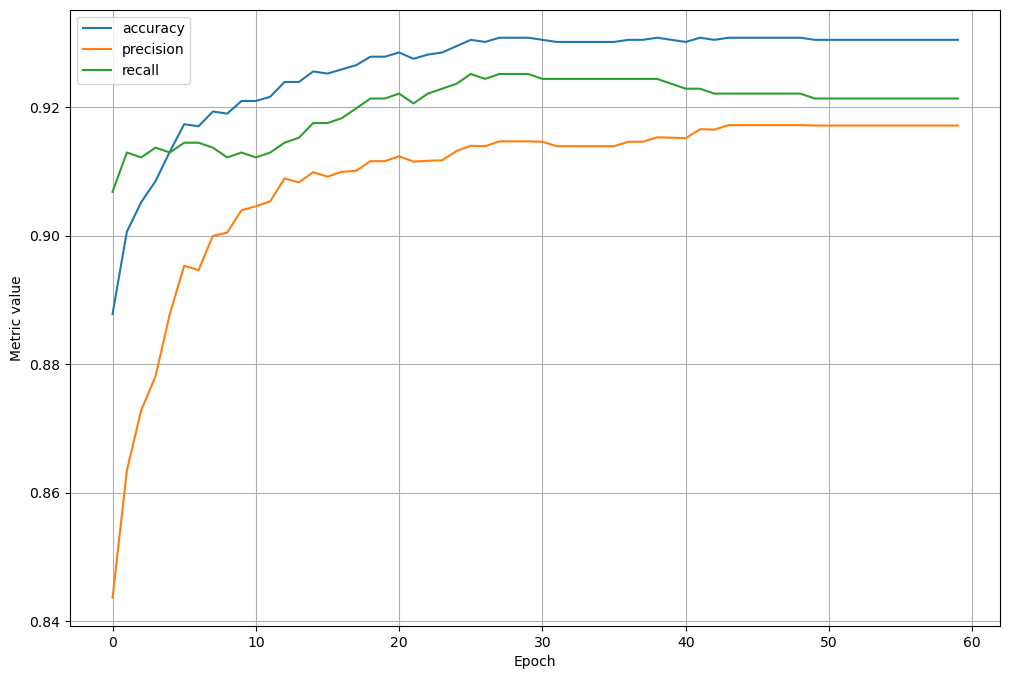

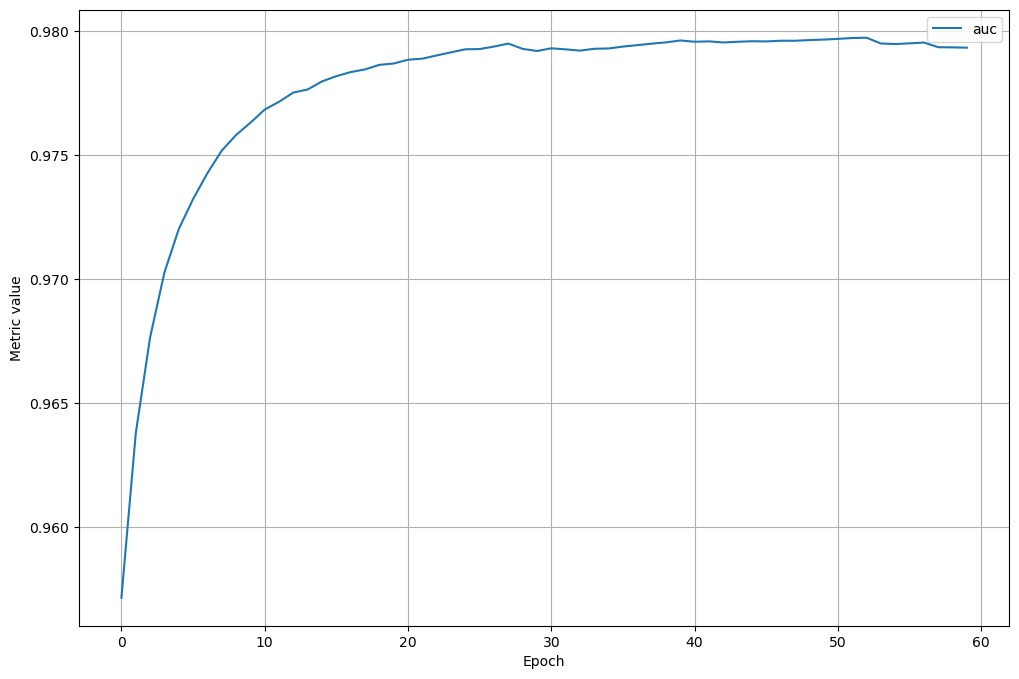

In [22]:
# Step 1: Define the settings for an experiment using all features.
# - This includes the hyperparameters (learning rate, epochs, batch size), 
#   the classification threshold, and all input features.
settings_all_features = ExperimentSettings(
    learning_rate=0.001,  # Learning rate: Determines how quickly the model updates weights.
    number_epochs=60,  # Number of complete passes through the training data.
    batch_size=100,  # Number of samples processed at once before updating weights.
    classification_threshold=0.5,  # Threshold for classifying outputs as 1 (positive) or 0 (negative).
    input_features=all_input_features,  # Use all available features as input.
)

# Step 2: Define the evaluation metrics to track during training.
# - These metrics provide insights into the model's performance on classification tasks.
metrics = [
    keras.metrics.BinaryAccuracy(  # Measures the percentage of correct predictions.
        name='accuracy',
        threshold=settings_all_features.classification_threshold,  # Use the defined classification threshold.
    ),
    keras.metrics.Precision(  # Measures the proportion of correctly identified positives out of all predicted positives.
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(  # Measures the proportion of actual positives correctly identified.
        name='recall',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.AUC(  # Computes the Area Under the Curve for the Receiver Operating Characteristic (ROC).
        num_thresholds=100,  # Use 100 thresholds for a finer AUC calculation.
        name='auc',
    ),
]

# Step 3: Create the model using the defined settings and metrics.
# - The model is a simple neural network configured for binary classification.
model_all_features = create_model(settings_all_features, metrics)

# Step 4: Train the model on the training dataset.
# - 'all features': The name of this experiment, used to track this run.
# - `train_features`: Input data from the training dataset.
# - `train_labels`: True labels for the training data.
# - `settings_all_features`: The hyperparameters and features specific to this experiment.
experiment_all_features = train_model(
    'all features',  # Name of the experiment.
    model_all_features,  # The created model.
    train_features,  # Features from the training set.
    train_labels,  # Labels for the training set.
    settings_all_features,  # Experiment settings.
)

# Step 5: Visualize the training metrics (accuracy, precision, recall) over epochs.
# - This plot shows how the model's performance evolves during training.
plot_experiment_metrics(
    experiment_all_features,  # The experiment containing training metrics.
    ['accuracy', 'precision', 'recall']  # Metrics to plot.
)

# Step 6: Plot the AUC metric over epochs in a separate graph.
# - AUC measures how well the model separates positive and negative classes.
plot_experiment_metrics(experiment_all_features, ['auc'])


## Evaluate full-featured model on test split

In [23]:
# Step 1: Evaluate the model using all features on the test dataset.
# - `experiment_all_features`: The experiment object containing the trained model and settings.
# - `test_features`: The features from the test dataset.
# - `test_labels`: The ground truth labels for the test dataset.
# - This function returns a dictionary (`test_metrics_all_features`) where keys are metric names 
#   (e.g., 'accuracy', 'precision') and values are their corresponding test dataset results.
test_metrics_all_features = evaluate_experiment(
    experiment_all_features,  # The trained experiment object.
    test_features,  # Features of the test set.
    test_labels,  # Labels of the test set.
)

# Step 2: Compare training metrics with test metrics to assess model generalization.
# - `experiment_all_features`: The experiment containing training metrics.
# - `test_metrics_all_features`: The dictionary of test metrics computed in the previous step.
# - This function prints each metric's value for both training and test datasets.
# - It helps identify if the model is overfitting (large gap between train and test metrics) 
#   or generalizing well (similar train and test metrics).
compare_train_test(experiment_all_features, test_metrics_all_features)


Comparing metrics between train and test:
------
Train accuracy: 0.9304
Test accuracy:  0.9213
------
Train auc: 0.9793
Test auc:  0.9761
------
Train loss: 0.1790
Test loss:  0.1900
------
Train precision: 0.9171
Test precision:  0.9067
------
Train recall: 0.9213
Test recall:  0.8947


This second model has very similar train and test metrics, suggesting it overfit less to the training data.

# Comparing our two models

With our simple experimentation framework, we can keep track of which experiments we ran, and what the results were. We can also define a helper function below which allows us to easily compare two or more models, both during training and when evaluated on the test set.

In [24]:
# Define a function to compare multiple experiments based on selected metrics.
def compare_experiment(
    experiments: list[Experiment],  # List of Experiment objects to compare.
    metrics_of_interest: list[str],  # Metrics to focus on (e.g., 'accuracy', 'precision').
    test_dataset: pd.DataFrame,  # Features from the test dataset.
    test_labels: np.array,  # Ground truth labels for the test dataset.
):
    """
    Compare train and test metrics across multiple experiments.

    Args:
    - experiments: List of Experiment objects containing models and training results.
    - metrics_of_interest: List of metric names to visualize and compare.
    - test_dataset: DataFrame containing test features.
    - test_labels: NumPy array of test labels.

    Raises:
    - ValueError: If a requested metric is not available in an experiment's metrics history.
    """
    # Step 1: Validate that all required metrics are available for each experiment.
    for metric in metrics_of_interest:
        for experiment in experiments:
            if metric not in experiment.metrics_history:
                raise ValueError(
                    f'Metric {metric} not available for experiment {experiment.name}'
                )

    # Step 2: Initialize the plot for comparison.
    fig = plt.figure(figsize=(12, 12))  # Set the figure size for the plot.
    
    # First subplot: Train metrics comparison
    ax = fig.add_subplot(2, 1, 1)  # Create the first subplot (2 rows, 1 column, 1st plot).
    ax.set_title('Train metrics')  # Title for the train metrics plot.

    # Define unique colors and markers for experiments and metrics.
    colors = [f'C{i}' for i in range(len(experiments))]  # Assign unique colors for each experiment.
    markers = ['.', '*', 'd', 's', 'p', 'x']  # Marker styles for each metric.
    marker_size = 10  # Size of the markers.

    # Step 3: Plot train metrics for each experiment.
    for i, metric in enumerate(metrics_of_interest):
        for j, experiment in enumerate(experiments):
            plt.plot(
                experiment.epochs,  # X-axis: Epochs.
                experiment.metrics_history[metric],  # Y-axis: Metric values.
                markevery=4,  # Markers appear every 4 points for clarity.
                marker=markers[i],  # Marker style for the metric.
                markersize=marker_size,  # Marker size.
                color=colors[j],  # Line color for the experiment.
            )

    # Step 4: Add a custom legend for the train metrics plot.
    legend_handles = []  # Handles for the legend.
    for i, metric in enumerate(metrics_of_interest):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                label=metric,  # Add legend entry for each metric.
                marker=markers[i],
                markersize=marker_size,
                c='k',  # Black marker for metric labels.
            )
        )
    for i, experiment in enumerate(experiments):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                label=experiment.name,  # Add legend entry for each experiment.
                color=colors[i],  # Experiment-specific color.
            )
        )
    ax.set_xlabel("Epoch")  # Label for the x-axis.
    ax.set_ylabel("Metric value")  # Label for the y-axis.
    ax.grid()  # Add a grid for easier visualization.
    ax.legend(handles=legend_handles)  # Add the legend to the plot.

    # Second subplot: Test metrics comparison
    ax = fig.add_subplot(2, 1, 2)  # Create the second subplot (2nd plot).
    spacing = 0.3  # Space between bars in the bar chart.
    n_bars = len(experiments)  # Number of experiments (used to space bars).
    bar_width = (1 - spacing) / n_bars  # Adjust bar width based on the number of experiments.

    # Step 5: Plot test metrics as a bar chart for each experiment.
    for i, experiment in enumerate(experiments):
        # Evaluate the experiment's model on the test dataset.
        test_metrics = evaluate_experiment(experiment, test_dataset, test_labels)

        # Set the position of bars for this experiment.
        x = np.arange(len(metrics_of_interest)) + bar_width * (i + 1 / 2 - n_bars / 2)

        # Plot the bar for each metric.
        ax.bar(
            x,
            [test_metrics[metric] for metric in metrics_of_interest],  # Test metric values.
            width=bar_width,  # Width of the bar.
            label=experiment.name,  # Label for this experiment.
        )

    # Add labels, grid, and legend for the test metrics plot.
    ax.set_xticks(np.arange(len(metrics_of_interest)))  # Set x-tick positions.
    ax.set_xticklabels(metrics_of_interest)  # Set x-tick labels to metric names.
    ax.set_title('Test metrics')  # Title for the test metrics plot.
    ax.set_ylabel('Metric value')  # Label for the y-axis.
    ax.set_axisbelow(True)  # Put the grid behind the bars.
    ax.grid()  # Add a grid for easier visualization.
    ax.legend()  # Add the legend to the plot.

# Print a message to confirm the function has been defined.
print('Defined function to compare experiments.')


Defined function to compare experiments.


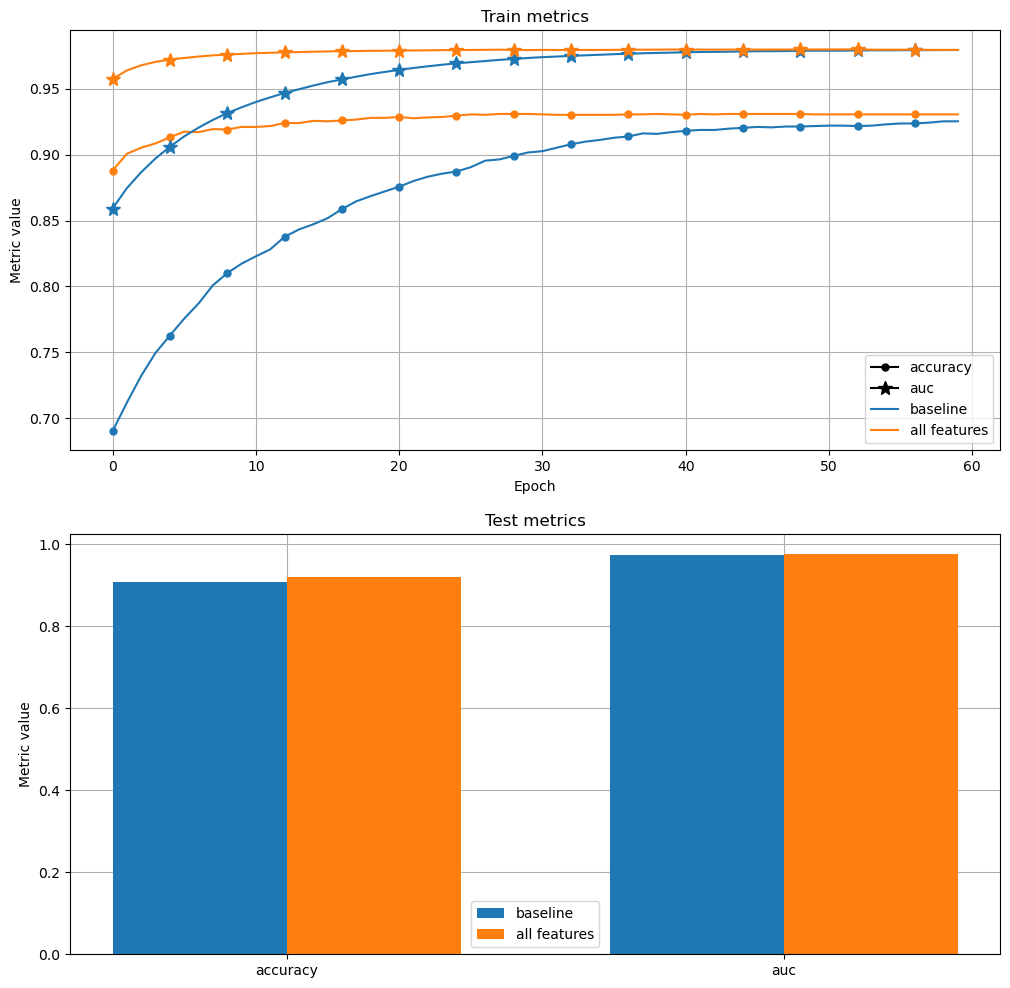

In [25]:
# Compare two experiments on selected metrics using the test dataset.

# - The first experiment, `experiment`, was trained with a subset of features.
# - The second experiment, `experiment_all_features`, was trained using all features.
# - The metrics to compare are 'accuracy' and 'auc' (Area Under the Curve).

compare_experiment(
    [experiment, experiment_all_features],  # List of experiments to compare.
    ['accuracy', 'auc'],  # Metrics to focus on during the comparison.
    test_features,  # Features from the test dataset.
    test_labels,  # Ground truth labels for the test dataset.
)


Comparing the two models, both have AUC of ~.97-.98. There does not seem to be a large gain in model quality when adding the other four features, which makes sense, given that many of the features (area, perimeter, and convex area, for example) are interrelated.